## Global Terrorist Attacks Modeling 

To predict the terrorist group which is responsible
of attacks and activities using historical data is a complicated
task due to the lake of detailed terrorist data. This notebook is
based on predicting terrorist groups responsible of attacks from year 1970 up to 2017 by using data mining
classification techniques.  


In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
from glob import glob
import os
import gensim 
import gensim.models.word2vec as w2v
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import stopwords
import nltk
stopwords_en = stopwords.words('english')
import warnings
warnings.filterwarnings('ignore')

In [2]:
gtd = pd.read_csv('df_select.csv')
gname = gtd['gname'].unique()
classes_code = pd.Categorical(gname).codes
classes = pd.Categorical(gname).categories

In [3]:
gtd.groupby('gname')['country'].nunique().sort_values(ascending=False).head(5)
gtd.groupby('country')['gname'].nunique().sort_values(ascending=False).head(5)
gtd['gname'].value_counts().head(5)/len(gtd['gname'])

Taliban                                             0.078823
Islamic State of Iraq and the Levant (ISIL)         0.059165
Shining Path (SL)                                   0.048013
Farabundo Marti National Liberation Front (FMLN)    0.035322
Al-Shabaab                                          0.034658
Name: gname, dtype: float64

Since there are so many classes, the imbalance problem is not pronounced. However, the consequent problem is that some classes have very low probablity.   

__Train-CrossValidation (Test) Spliting__ 

To classify, the real testset is the data that gname is unknown. So the splitting is more like the training and CV splitting. The dataset is large enough but we still used [k-fold cross validation](https://www.youtube.com/watch?v=6dbrR-WymjI) on the trainingset to evaluate the model to avoid the high variance of the cv(test) dataset. Advantages of k-fold cross validation: 1) more accurate estimate of out-of-sample accuracy 2) more efficient use of data.   

In [4]:
X = gtd.select_dtypes(include=[np.number])
y = gtd['gname']
code = {x:y for x, y in zip(classes,classes_code)}
y = y.map(code)    #y = pd.get_dummies(y) dummy will be much slower
#X = gtd[['iyear','country', 'attacktype1', 'weaptype1', 'targtype1','casualities','region']]
X=X.fillna(0) # maybe not a best choice, but just use 0 for now.  
# split the dataset for train and cross-validation 
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=0.1,random_state=101)

- __The Hamming loss__ is the fraction of labels that are incorrectly predicted (though often used in multi-label cases).
- __The Classification Accuracy__ is the percentage number of
correctly classified instances (the number of correct
predictions from all predictions made). 
- __F-Measure__ also called F-Score, it conveys the balance
between the precision and the recall. 

Notes: also want to try log-loss, but it does not work when the training set and test set have different labels. 

In [5]:
from sklearn.metrics import hamming_loss,accuracy_score,log_loss,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def evaluate_score(y_true,y_pred): 
    loss = hamming_loss(y_true,y_pred)
    print("Hamming_loss : {}".format(loss))
    accuracy = accuracy_score(y_true,y_pred)
    print("Accuracy : {}".format(accuracy))
    f1=f1_score(y_true,y_pred,average="weighted")
    print("F1 : {}".format(f1))

def print_model_results(model,name,cv,y,X):
    result_xgb = cross_val_score(model, X, y, cv=cv,scoring='accuracy')
    print('Cross Validation '+name,' ',np.mean(result_xgb))
    return np.mean(result_xgb)

### Models: 
__Decision Tree__

The simplest tree model. If the goal is better predictions, we should prefer RF, to reduce the variance.
If the goal is exploratory analysis, we should prefer a single DT, as to understand the data relationship in a tree hierarchy structure. Hyperparameter tuning with RandomizedSearchCV. 

Supported __criteria__ are “gini” for the Gini impurity and “entropy” for the information gain.
__max_depth__ represents the depth of the tree. The deeper the tree, the more splits it has and it captures more information about the data. 
__min_samples_leaf__ is The minimum number of samples required to be at a leaf node.
__max_features__ represents the number of features to consider when looking for the best split.
__min_samples_split__ represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier

In [7]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [8]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 32),
              "min_samples_split":randint(2, 10),
              "min_samples_leaf":randint(1, 10),
              "criterion": ["gini", "entropy"]}
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(estimator = tree, param_distributions = param_dist, \
            n_iter = 100, cv = 3, random_state=42, n_jobs = -1,scoring = 'accuracy').fit(X_train,y_train)

In [9]:
tree_cv.best_params_ 

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 30,
 'min_samples_leaf': 5,
 'min_samples_split': 8}

In [10]:
dt = DecisionTreeClassifier(criterion='entropy',max_features=30,min_samples_leaf=5,min_samples_split=8)
dt.fit(X_train, y_train)
cv_dt = print_model_results(dt,'DecisionTree',kfold,y_train,X_train)

Cross Validation DecisionTree   0.7738191443261538


In [11]:
predictions = dt.predict(X_cv)
evaluate_score(y_cv,predictions) #print(classification_report(y_cv, predictions))

Hamming_loss : 0.21195193929173692
Accuracy : 0.788048060708263
F1 : 0.7776589912194594


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0222961 to fit



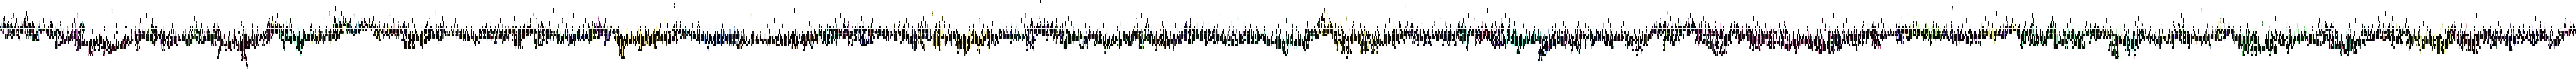

In [25]:
# Decision Tree Visualization 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(dt,feature_names=X_train.columns,out_file=None,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

__RandomForest__

In [12]:
from sklearn.ensemble import RandomForestClassifier
param_dist = {"max_features": randint(1, 32),
              "min_samples_split":randint(2, 10),
              "min_samples_leaf":randint(1, 10),
              "criterion": ["gini", "entropy"]}
forest = RandomForestClassifier()
forest_cv = RandomizedSearchCV(estimator = forest, param_distributions = param_dist, \
            n_iter = 50, cv = 3, random_state=42, n_jobs = -1,scoring = 'accuracy').fit(X_train,y_train)

In [13]:
forest_cv.best_params_ 

{'criterion': 'entropy',
 'max_features': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [15]:
rf = RandomForestClassifier(criterion='entropy',max_features=25,min_samples_leaf=1,min_samples_split=4)
rf.fit(X_train, y_train)
cv_rf = print_model_results(rf,'RF',kfold,y_train,X_train)

predictions = rf.predict(X_cv) 
evaluate_score(y_cv,predictions) 

Cross Validation RF   0.8048674794748369
Hamming_loss : 0.178752107925801
Accuracy : 0.821247892074199
F1 : 0.8119110203406648


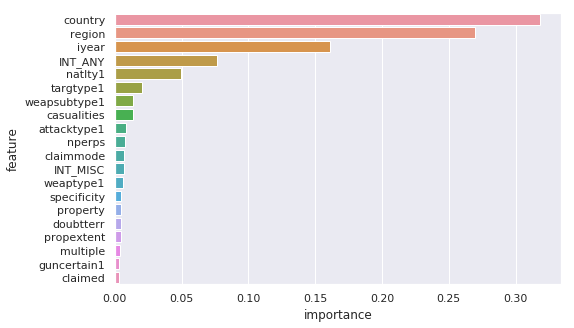

In [20]:
importances = list(rf.feature_importances_) ; feature_list = list(X.columns)
feature_importances = [(feature, importance) for feature, importance in \
                       zip(feature_list, importances)]
feature_importances = pd.DataFrame(feature_importances, columns=['feature','importance'])

feature_importances = feature_importances.sort_values(['importance'],\
                        ascending=False).reset_index(drop=True)

plt.subplots(figsize=(8, 5))
sns.barplot(y='feature', x='importance',data=feature_importances.iloc[:20])

__KNN__

K-Nearest Neighbor (KNN) Classifier is known as lazy learner or instance-based, in that it stores all of
the training samples and do not build a classifier until a new
sample needed to be classified that makes predictions based
on KNN labels assigned to test sample, KNN is based on
learning by analogy, and it is amongst the simplest of all
machine learning algorithms which can be used for prediction,
that is, to return a real valued prediction for a given unknown
sample. KNN is famous for its simplicity, applicability,
spontaneous maintenance. 

In [23]:
from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=5,metric='cityblock')  
knn.fit(X_train, y_train) 
cv_knn = print_model_results(knn,'knn',kfold,y_train,X_train)

Cross Validation knn   0.7037232235925184


In [24]:
predictions = knn.predict(X_cv)  
evaluate_score(y_cv,predictions) 
#print(classification_report(y_cv, ylabel))

Hamming_loss : 0.27613827993254636
Accuracy : 0.7238617200674536
F1 : 0.70196115463904


__Neutral Network__

- input_dim - number of columns of the dataset.

- output_dim - number of outputs to be fed to the next layer, if any.

- activation - activation function. 


[sparse_categorical_crossentropy](sparse_categorical_crossentropy) allows the target classes accepted as integers. 

In [88]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,Embedding
from keras.utils import np_utils
from keras.utils import to_categorical

In [89]:
#y_encoded = to_categorical(y,num_classes=None)
#np.shape(y_encoded)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=0.1,random_state=101)

In [99]:
model = Sequential()
#model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(input_dim=32, activation='relu',output_dim=64))
model.add(Dense(output_dim=32,activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(output_dim=32,activation='relu'))
#model.add(Dense(output_dim=20,activation='relu'))
model.add(Dense(936,activation='softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])

his = model.fit(X_train, y_train, batch_size=16, nb_epoch=15,validation_data=(X_cv, y_cv))

Train on 85383 samples, validate on 9488 samples
Epoch 1/15
85383/85383 [==============================] - 30s 355us/step - loss: 5.2324 - sparse_categorical_accuracy: 0.1174 - val_loss: 4.7549 - val_sparse_categorical_accuracy: 0.1634
Epoch 2/15
85383/85383 [==============================] - 31s 367us/step - loss: 4.5368 - sparse_categorical_accuracy: 0.1782 - val_loss: 4.0971 - val_sparse_categorical_accuracy: 0.2448
Epoch 3/15
85383/85383 [==============================] - 29s 345us/step - loss: 3.6373 - sparse_categorical_accuracy: 0.3065 - val_loss: 3.2937 - val_sparse_categorical_accuracy: 0.3603
Epoch 4/15
85383/85383 [==============================] - 29s 339us/step - loss: 3.0571 - sparse_categorical_accuracy: 0.4136 - val_loss: 2.8337 - val_sparse_categorical_accuracy: 0.4429
Epoch 5/15
85383/85383 [==============================] - 28s 332us/step - loss: 2.6268 - sparse_categorical_accuracy: 0.4729 - val_loss: 2.5761 - val_sparse_categorical_accuracy: 0.4847
Epoch 6/15
85383

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                1320      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_11 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_12 (Dense)             (None, 936)               38376     
Total params: 42,166
Trainable params: 42,166
Non-trainable params: 0
_________________________________________________________________


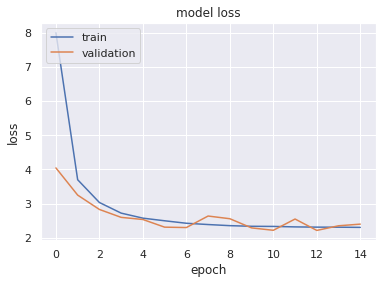

In [93]:
# summarize history for loss
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [94]:
score = model.evaluate(X_cv, y_cv, verbose=0)
print('loss',score[0],'accuracy',score[1])
y_pred = model.predict(X_cv)
evaluate_score(y_cv,np.argmax(y_pred,axis=1))

loss 2.3996580240095247 accuracy 0.502845699831366
Hamming_loss : 0.49715430016863404
Accuracy : 0.502845699831366
F1 : 0.40469306480056205


In [79]:
test = pd.read_csv('test.csv')
X_test = test.select_dtypes(include=[np.number])
y_test = rf.predict(X_test.fillna(0))

code_re = {x:y for x, y in zip(classes_code,classes)}
y_test = pd.Series(y_test).map(code_re)

y_test.value_counts().head(5)

Muslim extremists    21772
Gunmen                5951
Militants             4041
Tribesmen             3825
Separatists           3514
dtype: int64

### Extra Exploration: Hierarchy Clustering of Terror Groups Names  

In [40]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
def process_text(text,stem=False):
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    if stem:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [43]:
#gname_tagged = TaggedDocument(gname_split,tags['group'])
#model = Doc2Vec(gname_split)
#print("Word2Vec vocabulary length:", len(model.wv.vocab))
#model.train(gname_split,total_examples=3536,epochs=2)
#model.wv.most_similar('good',  topn=15) #gname_split
#vector = model.wv.syn0
#gname_split = [s.lower().replace('(','').replace(')','').split(' ') for s in gname]
#model = w2v.Word2Vec(gname_split,size=3000, min_count=1, window = 6)
#model.build_vocab(gname_split)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vect = CountVectorizer()
gname_vect = vect.fit_transform(gname)
print(len(vect.vocabulary_))

1399


In [45]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram,linkage
gname_red = SpectralEmbedding(n_components=2).fit_transform(gname_vect.toarray())

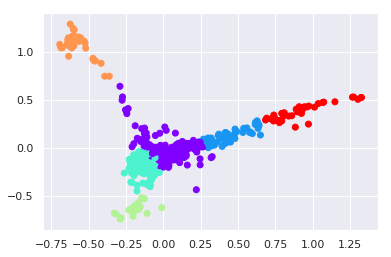

In [46]:
clustering = AgglomerativeClustering(linkage='ward',affinity='euclidean',n_clusters = 6)
clustering.fit_predict(gname_red) 
plt.scatter(gname_red[:,0],gname_red[:,1], c=clustering.labels_, cmap='rainbow')  

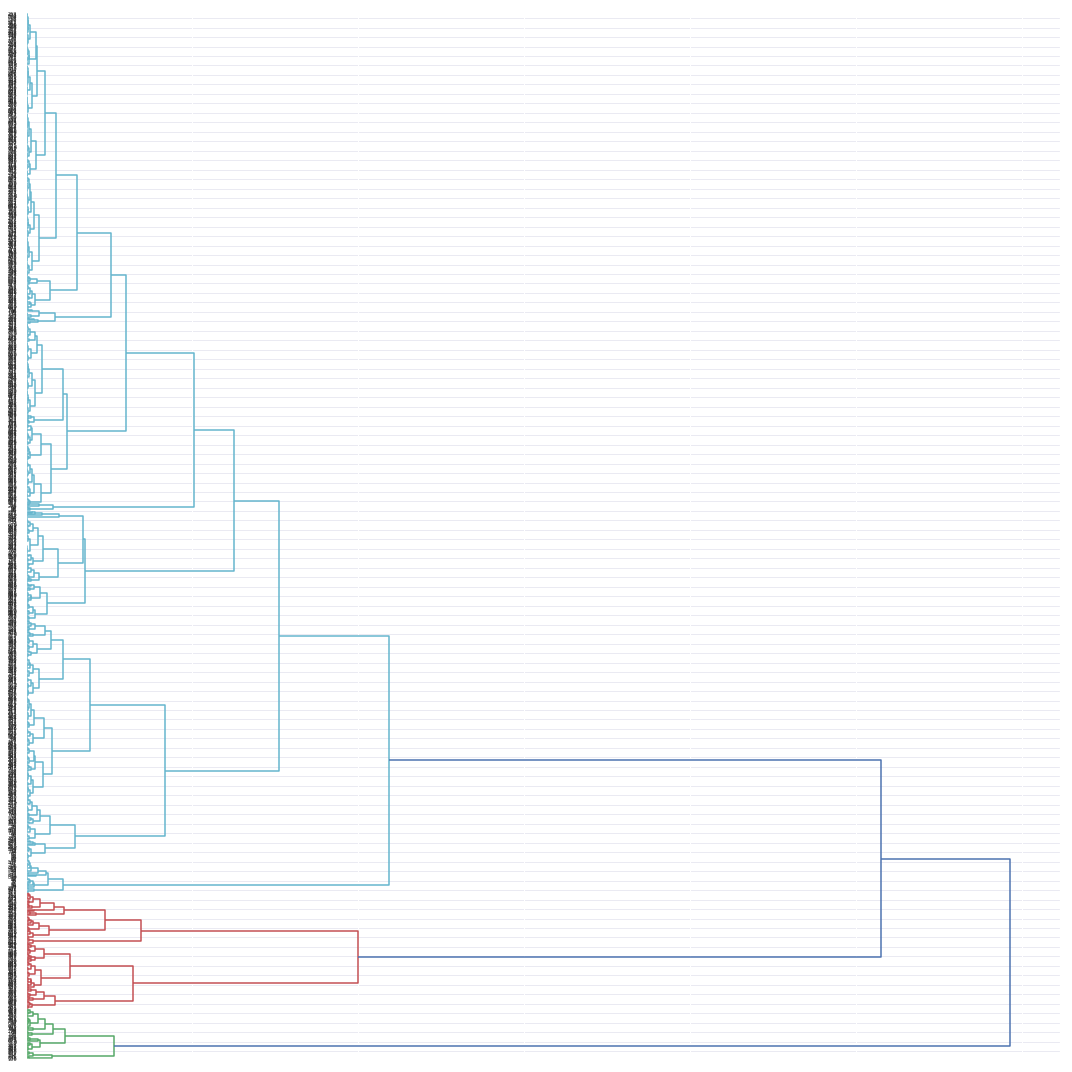

In [213]:
Z = linkage(gname_red, 'ward')#define the linkage_matrix using ward clustering pre-computed distances
fig, ax = plt.subplots(figsize=(15,15)) # set size

ax = dendrogram(Z, orientation="right",labels=classes_code)
plt.tick_params(axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout


In [214]:
gname_label = pd.DataFrame({'gname':gname,'label':clustering.labels_})

In [215]:
print("Top terms per cluster:")

gname_label = pd.DataFrame({'gname':gname,'label':clustering.labels_})
 # Add column corresponding to cluster number
word_frequencies_by_cluster = gname_label.groupby('label').sum()

Top terms per cluster:


In [217]:
gname_label['label'].value_counts()

0    543
2    214
1     58
5     46
4     45
3     30
Name: label, dtype: int64

__Summary:
This was a quick try at creating models to predict unattributed terrorist attacks. There are several thoughts, caveats and to-do discussed here.__

__Data imcompleteness: A lot of features are highly missed, which makes them less useful. With the features readily available in the database, such as country, year, and city, there might be more features that can be collected and be considered, e.g., the religion of the country, and the proverty.__

__The size of the target classes is big and quite some terror groups have little attack information (manually selected 5 attacks as the threshold). It is one of the challenges of the project.__

__Tree models work well in this problem. Among all these models, random forest has the best performance. Maybe try more other models in the future or try the social/behavior analysis of each group discussed in the [paper](https://www.hindawi.com/journals/ddns/2018/5676712/).__

__Text feature is not used in this project. Text mining might provide new information on the problem. Worth trying__ 

__Future Recommendation:
Geo-location is an important feature to determine the attack groups as shown in our model. Each group has its own active region. Mid-East has more attack terror groups and attacks in the history data. Monitoring the high risk regions and active groups is essential for governor.__  



